# **Weighted Ensemble**  

###### contributed by **Hima Varshini Parasa**

In [1]:
# Install necessary packages
!pip install scikit-learn pandas numpy

Saving prediction_labels.csv to prediction_labels (3).csv

--- Ensemble Model Performance ---

Optimized Weights:
VADER: 0.0792
DISTILLBERT: 0.2975
ROBERTA: 0.1052
BertTweet: 0.1638
gpt2: 0.2241
FINBERT: 0.1301

Training Performance:
              precision    recall  f1-score   support

           0       0.91      0.83      0.86      2780
           1       0.58      0.73      0.65      1686
           2       0.89      0.83      0.86      2529

    accuracy                           0.80      6995
   macro avg       0.79      0.80      0.79      6995
weighted avg       0.82      0.80      0.81      6995


Test Performance:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       710
           1       0.60      0.72      0.66       461
           2       0.86      0.83      0.84       578

    accuracy                           0.80      1749
   macro avg       0.79      0.79      0.79      1749
weighted avg       0.81      0.80      0

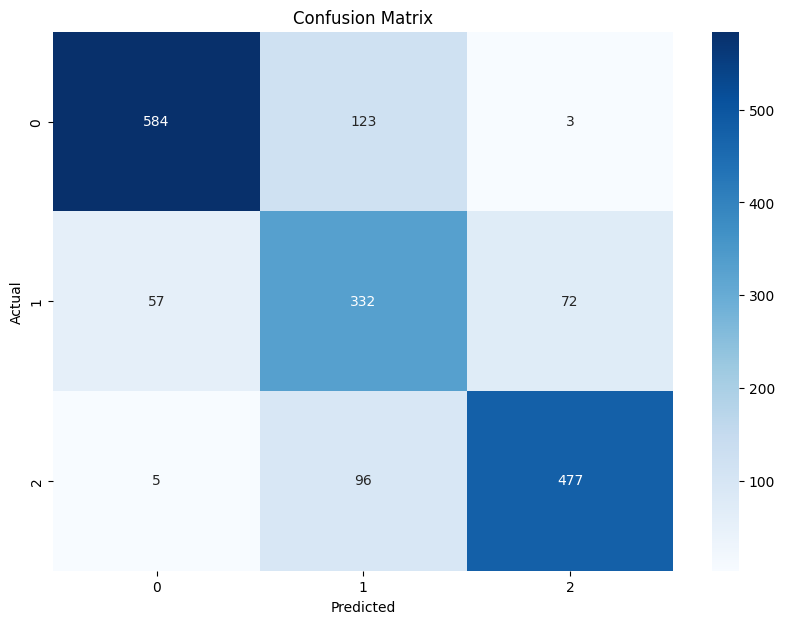


--- Individual Model Performances ---

VADER Performance:
              precision    recall  f1-score   support

           0       0.70      0.65      0.67       710
           1       0.47      0.32      0.38       461
           2       0.53      0.71      0.61       578

    accuracy                           0.58      1749
   macro avg       0.57      0.56      0.55      1749
weighted avg       0.58      0.58      0.57      1749


DISTILLBERT Performance:
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       710
           1       0.72      0.82      0.77       461
           2       0.85      0.93      0.89       578

    accuracy                           0.85      1749
   macro avg       0.85      0.85      0.85      1749
weighted avg       0.87      0.85      0.86      1749


ROBERTA Performance:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       710
           1       0.7

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# Install necessary libraries in Colab (if needed)
!pip install scikit-learn pandas numpy

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import json
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

class EnsembleModelTrainer:
    def __init__(self, csv_path, model_columns, label_column='label', text_column='text'):
        """
        Initialize ensemble model trainer

        Parameters:
        - csv_path: Path to the CSV file
        - model_columns: List of columns with model predictions
        - label_column: Column name for true labels
        - text_column: Column name for text data
        """
        # Read CSV
        self.df = pd.read_csv(csv_path)

        # Columns
        self.model_columns = model_columns
        self.label_column = label_column
        self.text_column = text_column

        # Label encoding
        self.label_encoder = LabelEncoder()
        self.df['label_encoded'] = self.label_encoder.fit_transform(self.df[label_column])

    def prepare_data(self, test_size=0.2, random_state=42):
        """
        Prepare data for training and testing

        Parameters:
        - test_size: Proportion of test data
        - random_state: Random seed for reproducibility

        Returns:
        - Train and test splits
        """
        # Prepare features
        X = self.df[self.model_columns + [self.text_column]]
        y = self.df['label_encoded']

        # Split data
        return train_test_split(X, y, test_size=test_size, random_state=random_state)

    def optimize_weights(self, X_train, y_train, model_columns):
        """
        Optimize ensemble weights

        Parameters:
        - X_train: Training data
        - y_train: Training labels
        - model_columns: Model prediction columns

        Returns:
        - Optimized weights
        """
        # Initial equal weights
        weights = np.ones(len(model_columns)) / len(model_columns)
        best_weights = weights
        best_accuracy = 0

        # Weight optimization iterations
        for _ in range(500):
            # Random weight perturbation
            current_weights = weights + np.random.normal(0, 0.05, len(weights))
            current_weights = np.abs(current_weights)  # Ensure non-negative
            current_weights /= current_weights.sum()  # Normalize

            # Compute weighted predictions
            weighted_train_preds = np.zeros(len(X_train))
            for col, weight in zip(model_columns, current_weights):
                weighted_train_preds += X_train[col].astype(float) * weight

            # Round to integer predictions
            train_preds = np.round(weighted_train_preds).astype(int)

            # Compute accuracy
            current_accuracy = accuracy_score(y_train, train_preds)

            # Update if better
            if current_accuracy > best_accuracy:
                best_accuracy = current_accuracy
                best_weights = current_weights

        return best_weights

    def ensemble_predict(self, X, weights):
        """
        Generate ensemble predictions

        Parameters:
        - X: Input data
        - weights: Model weights

        Returns:
        - Ensemble predictions
        """
        # Weighted prediction
        weighted_preds = np.zeros(len(X))
        for col, weight in zip(self.model_columns, weights):
            weighted_preds += X[col].astype(float) * weight

        return np.round(weighted_preds).astype(int)

    def train_and_evaluate(self):
        """
        Train ensemble model and evaluate performance

        Returns:
        - Performance metrics
        """
        # Prepare data
        X_train, X_test, y_train, y_test = self.prepare_data()

        # Optimize weights
        optimized_weights = self.optimize_weights(X_train, y_train, self.model_columns)

        # Ensemble predictions
        ensemble_train_preds = self.ensemble_predict(X_train, optimized_weights)
        ensemble_test_preds = self.ensemble_predict(X_test, optimized_weights)

        # Performance metrics
        print("\n--- Ensemble Model Performance ---")
        print("\nOptimized Weights:")
        for model, weight in zip(self.model_columns, optimized_weights):
            print(f"{model}: {weight:.4f}")

        print("\nTraining Performance:")
        print(classification_report(y_train, ensemble_train_preds))

        print("\nTest Performance:")
        print(classification_report(y_test, ensemble_test_preds))

        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, ensemble_test_preds))
        cm = confusion_matrix(y_test, ensemble_test_preds)
        print(cm)

        # Plot confusion matrix
        self.plot_confusion_matrix(cm, self.label_encoder.classes_)


        # Individual model performances
        print("\n--- Individual Model Performances ---")
        for col in self.model_columns:
            print(f"\n{col} Performance:")
            individual_preds = X_test[col].astype(int)
            print(classification_report(y_test, individual_preds))

        return {
            'ensemble_weights': dict(zip(self.model_columns, optimized_weights)),
            'ensemble_test_performance': classification_report(y_test, ensemble_test_preds, output_dict=True)
        }
    def plot_confusion_matrix(self, cm, class_labels):
        """
        Plot confusion matrix using seaborn

        Parameters:
        - cm: Confusion matrix
        - class_labels: List of class labels
        """
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()


def main():
    # Define model columns (adjust as per your CSV)
    model_columns = [
        'VADER',
        'DISTILLBERT',
        'ROBERTA',
        'BertTweet',
        'gpt2',
        'FINBERT'
    ]

    # Allow user to upload the CSV file
    uploaded = files.upload()  # Prompt the user to upload a file
    csv_path = list(uploaded.keys())[0]  # Get the file name from the uploaded file

    # Initialize and run ensemble model
    ensemble_trainer = EnsembleModelTrainer(
        csv_path=csv_path,
        model_columns=model_columns
    )

    # Train and evaluate
    results = ensemble_trainer.train_and_evaluate()

    # Save results as a JSON file to Colab's local storage
    with open('ensemble_results.json', 'w') as f:
        json.dump(results, f, indent=4)

    # Provide a download link for the results
    files.download('ensemble_results.json')

# Call the main function directly
main()



**Results**
```

{
    "ensemble_weights": {
        "VADER": 0.11884329207489726,
        "DISTILLBERT": 0.24787704319701978,
        "ROBERTA": 0.1630954915818285,
        "BertTweet": 0.2244648232416309,
        "gpt2": 0.20972041912902425,
        "FINBERT": 0.035998930775599444
    },
    "ensemble_test_performance": {
        "0": {
            "precision": 0.873546511627907,
            "recall": 0.8464788732394366,
            "f1-score": 0.8597997138769671,
            "support": 710.0
        },
        "1": {
            "precision": 0.6373165618448637,
            "recall": 0.6594360086767896,
            "f1-score": 0.6481876332622601,
            "support": 461.0
        },
        "2": {
            "precision": 0.839041095890411,
            "recall": 0.8477508650519031,
            "f1-score": 0.8433734939759037,
            "support": 578.0
        },
        "accuracy": 0.7975986277873071,
        "macro avg": {
            "precision": 0.7833013897877272,
            "recall": 0.7845552489893765,
            "f1-score": 0.783786947038377,
            "support": 1749.0
        },
        "weighted avg": {
            "precision": 0.7998780512812771,
            "recall": 0.7975986277873071,
            "f1-score": 0.7985947257316299,
            "support": 1749.0
        }
    }
}

```



In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the CSV file
data = pd.read_csv('/content/prediction_labels.csv')

# Define the columns for the model predictions
model_columns = ['VADER', 'DISTILLBERT', 'ROBERTA', 'BertTweet', 'gpt2', 'FINBERT']

# Split into features and target
X = data[model_columns]  # Predictions from the 6 LLMs
y = data['label']        # True sentiment

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Manually set weights for the predictions from the 6 LLMs
# Ensure the weights sum to 1
manual_weights = [0.15, 0.25, 0.25, 0.20, 0.10, 0.05]

# Convert weights to numpy array for easier manipulation
manual_weights = np.array(manual_weights)

# Ensure weights sum to 1
manual_weights = manual_weights / np.sum(manual_weights)

# Print the manual weights
print("Manual Weights:", manual_weights)

# Predict on the test set using the manually set weights
weighted_predictions_test = np.average(X_test, axis=1, weights=manual_weights)
weighted_predictions_test = np.round(weighted_predictions_test).astype(int)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, weighted_predictions_test)
print("Ensemble Model Accuracy:", accuracy)


Manual Weights: [0.15 0.25 0.25 0.2  0.1  0.05]
Ensemble Model Accuracy: 0.8061749571183533
